# What does the world think of us?
What’s the best thing about Switzerland? -- I don't know, but the flag is a big plus! Joke aside, we want to highlight how one country is seen by other countries of the world. Is it seen positively or negatively ? Is this country even known from the others ? These questions are an example of what we want to answer.<br><br>
To study the feeling of countries towards each other, we use the GDELT Project dataset :<br>
>"Supported by Google Jigsaw, the GDELT Project monitors the world's broadcast, print, and web news from nearly every corner of every country in over 100 languages and identifies the people, locations, organizations, themes, sources, emotions, counts, quotes, images and events driving our global society every second of every day, creating a free open platform for computing on the entire world."<br>
https://www.gdeltproject.org/

More precisely, to answer our questions, we will exploit the tone of reported events to classify countries and display beautifuls graphics about thier relations. We follow this plan in this notebook:
1. Data extraction, cleaning and exploration
2. Choice of the statistics
3. Study of chosen and representative cases
4. Presentation of the goals for the next milestone
5. Data analysis corresponding to the data-story

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import networkx as nx

import seaborn as sns
sns.set_context("notebook")

import plotly.plotly as py
from scipy.stats import norm
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram

from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

DATA_DIR = 'data'
GEN_DIR = os.path.join('data story', 'plots')
MIN_CONSIDER = 2000  # minimum number of datapoints to consider the data
MIN_CI = 10000  # minimum number of datapoints under which we assume the normal mean assumption holds

## 1. Data extraction, cleaning and exploration
#### Get the data from csv files that are produced by the python scripts we run on the cluster

In [2]:
# load the mean tone a country has about itself
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_inner_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_type_view.csv'))
country_outer_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_type_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv.zip'))

# these files are only used to show some distributions and will not be used 
# for the data analisys later on
afghanistan_inner = pd.read_csv(os.path.join(DATA_DIR, 'afg_inner.csv'))
ivory_coast_outer = pd.read_csv(os.path.join(DATA_DIR, 'ivory_outer.csv'))
mexico_inner = pd.read_csv(os.path.join(DATA_DIR, 'mexico_inner.csv'))
algeria_inner = pd.read_csv(os.path.join(DATA_DIR, 'algeria_inner.csv'))
tuvalu_outer = pd.read_csv(os.path.join(DATA_DIR, 'tuvalu_outer.csv'))

# repartition of the types of each country's actor when dividing the medias by their size
type_repartition = pd.read_csv(os.path.join(DATA_DIR, "type_repartition.csv"))

# you won't find web scarping code for this dataframe because we manually parsed it 
# (multiline selections in sublime text) because it was faster
r_w_b_2016 = pd.read_csv(os.path.join(DATA_DIR, 'R_W_B_2016.csv'))

country_codes = pd.read_csv(os.path.join(DATA_DIR, 'mapping_country_codes.csv')).drop(
    "Unnamed: 0", axis=1)  # needed for plotly
country_codes.columns = ["country_name", "country_ISO"]

These files contains the same statistical informations for several use cases (what a country thinks of another, difference between types of actors from a country, difference from news sources from a country, ...). The statistical info we chose to extract from the data is always the same, namely:
    - avg_tone: the average tone used by the mentions that corresponds to the row
    - stddev_tone: standard deviation of the average tone
    - count_mentions: number of mentions in the row
    - count_events: number of distinct events in the row (if there are 10 mentions to the same event, count_mentions=10 and count_events=1)
    - avg_conf: average confidence of GDELT into the informations it parsed
    - avg_weighted_tone: average tone weighted by the confidence of GDELT (avg(Tone*Confidence)/avg_conf)
    - std_weighted_tone: std of the weighted tone (std(Tone*Confidence)/avg_conf)
    - first_quartile_tone: first quartile of the tone
    - median_tone: median of the tone
    - third_quartile_tone: third quartile of the tone

In [3]:
# statistical informations about the tone of the news of a country towards another
country_to_country_view.head()

,actor_country,mention_country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Botswana,-1.942005,3.236105,15,15,43.333333,-1.981697,5.082414,-3.574975,-1.971522,-0.603865
1,Albania,Jersey,-5.202312,0.000000,2,2,100.000000,-5.202312,0.000000,-5.202312,-5.202312,-5.202312
2,Albania,Kenya,-2.902415,2.918567,98,54,41.428571,-2.822658,4.137127,-5.345502,-1.954397,-0.400534
3,Antigua and Barbuda,Armenia,-7.448764,3.566137,10,6,49.000000,-7.776772,4.736934,-10.194175,-10.194175,-3.921569
4,Antigua and Barbuda,Russia,-1.930421,3.658752,81,79,45.679012,-2.430936,5.551305,-2.910855,-1.479915,0.000000


In [4]:
# statistical informations about the tone of the news of a country towards itself
country_inner_view.head() # country_inner_type_view is exactly the same with 
# actor type information added

,country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Yemen,-3.608844,3.585294,10106,8795,44.735801,-3.732185,5.313685,-5.907173,-3.703704,-1.476015
1,Guyana,-2.180227,3.886347,54161,48270,42.249958,-1.987313,4.733579,-4.572565,-1.884701,0.412088
2,Malaysia,-1.757954,3.398342,604138,397239,46.975228,-1.666103,4.283756,-3.859649,-1.646091,0.540541
3,Singapore,-1.133022,3.766699,175191,81500,53.444127,-1.091853,4.470803,-3.529412,-0.784314,1.450677
4,Iraq,-3.648960,3.098804,108114,72500,40.784357,-3.835942,5.053808,-5.543307,-3.500761,-1.586561


In [5]:
# statistical informations about the tone of the news of the external world towards a country
country_outer_view.head() # country_outer_type_view is exactly the same with 
# actor type information added

,country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Sweden,-3.203392,4.358988,894190,258716,38.043637,-3.020489,5.859831,-6.450158,-3.507653,0.000000
1,Turkey,-4.294582,3.161181,5667893,1513501,37.188643,-4.392249,5.471518,-6.270627,-4.280657,-2.380067
2,Iraq,-3.928116,2.766600,3692731,967934,37.603890,-4.023942,4.794569,-5.518170,-3.817365,-2.182891
3,Sudan,-4.040600,3.478347,552304,208709,36.107289,-4.086113,5.714121,-6.212425,-4.063745,-2.046784
4,Angola,-2.969994,3.881757,116007,49674,38.676632,-2.817222,5.518754,-5.847953,-3.151862,0.000000


In [6]:
# statistical informations about the tone of the news of a country towards the type (government,
# buisnesses,...) of another country
country_to_type_view.head()

,actor_country,mention_country,actor_type,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Barbados,GOV,-6.736422,3.256033,16,16,36.875000,-6.656401,6.535354,-9.271523,-9.233792,-4.612546
1,Afghanistan,China,RAD,-2.611754,1.093688,9,5,45.555556,-2.327217,1.537660,-2.247191,-2.247191,-2.247191
2,Afghanistan,Gambia,INS,-4.517831,1.231363,3,3,46.666667,-4.619392,3.767840,-5.228758,-5.228758,-3.095975
3,Afghanistan,North Korea,INS,-5.960580,3.075897,49,49,46.122449,-5.637655,4.869529,-6.572165,-6.571429,-4.852071
4,Afghanistan,Poland,UAF,2.640371,1.299043,7,2,51.428571,2.616605,1.548303,0.985222,3.050847,4.081633


In [7]:
# statistical informations about the tone of the news from a media (website) towards a country
media_to_country_view.head()

,actor_country,source_country,source_name,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Australia,governmentnews.com.au,-1.318458,0.000000,1,1,50.000000,-1.318458,0.000000,-1.318458,-1.318458,-1.318458
1,Afghanistan,Austria,ots.at,5.314010,0.000000,6,6,16.666667,5.314010,3.292971,5.314010,5.314010,5.314010
2,Afghanistan,Benin,bittenus.com,1.765772,1.521576,11,10,50.909091,2.035957,1.765785,2.008032,2.012349,2.230971
3,Afghanistan,Canada,dailyheraldtribune.com,-4.650001,3.254665,13,13,54.615385,-4.562309,5.953714,-6.433824,-6.433824,-4.444444
4,Afghanistan,Canada,infotel.ca,-4.742726,3.513820,1963,1900,37.677025,-4.854639,5.871267,-6.726457,-4.341534,-2.343750


## 2. Choice of the statistics
### 2.A. What statistic to use
We can see from the following plots that the average confidence for the dataframes country_inner_view and country_outer_view vary quite a bit (even tough these are the largest dataset) weighting the tone by the confidence thus makes sense. We should however be cautious with that parameter since it lowers the importance of news that have a low confidence which might lead to bias (ex: most journals in Afghanistan are in afghan except for a few pro-american websites that are in english), due to the language used, the english website news have a much more confidence than the others and thus, Afghanistan seem to dislike the US less than it does in reality). This does not mean that weighting w.r.t. avg_confindence is a bad thing but that it should not be forgotten when analizing results.

The quartiles have the advantage of being robust to outliers but are harder to combine (we cannot get the median tone of the outer_view of Syria from the median tones of the view of every country towards Syria) whereas it's easy for mean and feasible for std.

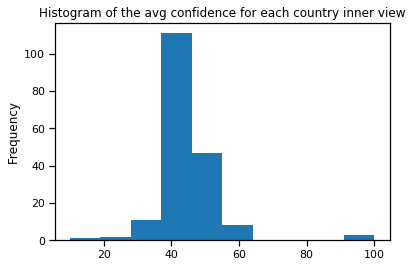

In [8]:
country_inner_view.avg_conf.plot(kind="hist", 
                        title="Histogram of the avg confidence for each country inner view");

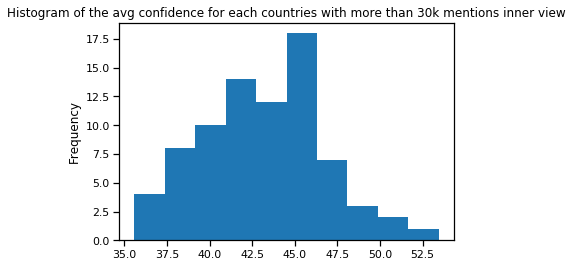

In [9]:
country_inner_view[country_inner_view.count_mentions > 30000].avg_conf.plot(kind="hist",
title="Histogram of the avg confidence for each countries with more than 30k mentions inner view");

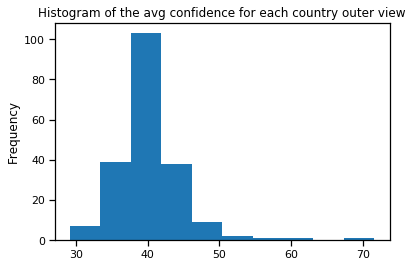

In [10]:
country_outer_view.avg_conf.plot(kind="hist",
                    title="Histogram of the avg confidence for each country outer view");


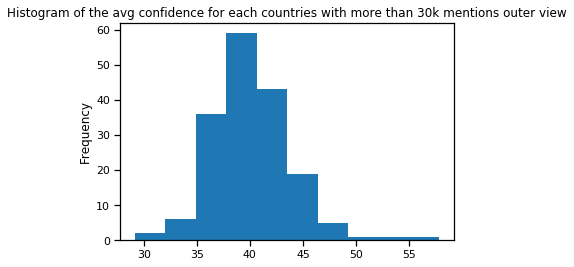

In [11]:
country_outer_view[country_outer_view.count_mentions > 30000].avg_conf.plot(kind="hist",
title="Histogram of the avg confidence for each countries with more than 30k mentions outer view");

### 2.B. What about confidence intervals?
A very important thing when dealing with data is to assess its reliability, for example through confidence intervals. Unfortunately, in our case, we do not have the ressources to compute non parametric confidence intervals (for example trough bootstrap resampling). A solution would be to use parametric estimation, assuming the tone is normally distributed. By using the mean, std and quartiles of the tone, we can get a metric expressing how much the data is normally distributed. If we standardize the tone by mean and std, the median tone should be 0 and the 1st and 3rd quartiles -0.6745 and 0.6745, computing the MSE between these data and what they should be give us an estimate on the "normality" of the data. Please note that this metric is very approximate since we only use three points and that there are also errors coming from the computation by spark of the median and quantiles themselves since spark only approximates them. We can however note two things from the following scatterplots:
    - the metric improves with the number of mentions (altough not that much)
    - more importantly, the errors are *huge*, since we are plotting the MSE w.r.t. to values of 0 and +- 0.6745, a MSE of 0.2 is very bad.
Using normal parametrization is thus not reliable either.
To get more insight about the look of the tone distributions, we chose to show up 5 cases, the inner_view of Afghanistan (176586 samples, sqrt(MSE)=0.02), the inner_view of Mexico (29682 samples, sqrt(MSE)=0.065), the inner view of Algeria (10695 samples, sqrt(MSE)=0.29), the outer view of Tuvalu (15530 samples, sqrt(MSE)=0.53) and the outer_view of the Ivory Coast (105428 samples, sqrt(MSE)=0.17). We can see that Afganistant looks more or less normal, mexico a bit less and ivory coast, Tuvalu and Algeria even less (it even doesn't look symmetric). We can also see that some of them have a 'gap' at 0 meaning that very small tone values are very unlikely (which makes sense) and that mexico has a several hundreds of tones that are set to exaclty 0.  

However, the mean might be normally distributed even tough the distribution isn't, indeed, the continuous limit theorem states that as n converges towards infinity, the mean of iid samples drawn from any distributions is a $N(\mu, \sigma^2/n)$ variable. We can compare the intervals assuming the CLT holds and the ones obtained by bootstrapping and we can see that these are quite close.  

As a conclusion, provided we have enough samples (which is the case for most of inner and outer view but not for other dataframes). Assuming the mean is normally distributed makes sense altough the tone itself isn't. We will use normal confidence intervals in the later when the number of mentions is above 10000.

In [12]:
def add_sqrt_MSE_with_gaussian_quartiles(df):
    """
    assuming the tone is distributed as a gaussian, the normalized quartiles and 
    median should be approximately equal to the ones of a gaussian distribution 
    (Q1(gaussian) = -0.6745, Q2(gaussian) = 0, Q3(gaussian) = 0.6745).
    
    For rows with a number of mentions of 1, this will return NaN
    """
    q1_squared_error = ((df.first_quartile_tone - df.avg_tone) / df.std_tone + 0.6745)**2
    median_squared_error = ((df.median_tone - df.avg_tone) / df.std_tone)**2
    q3_squared_error = ((df.third_quartile_tone - df.avg_tone) / df.std_tone - 0.6745)**2
    df["sqrt_gaussian_quartile_MSE"] = (q1_squared_error + median_squared_error
                                        + q3_squared_error)**0.5
    return df

In [13]:
def get_mean_bounds_bootstrapping(serie, nbr_boostrap_samples=150, alpha=0.05):
    """
    get confidence intervals obtained by bootstrapping for the mean of the given pandas' serie
    by using nbr_boostrap_samples bootstrap samples and with an alpha given as argument
    
    we reused this code from homework 3
    """
    bound_offset = nbr_boostrap_samples * alpha/2
    min_bound_offset = int(round(bound_offset))
    max_bound_offset = int(round(nbr_boostrap_samples - 1 - bound_offset))

    # Initalising the samples, the means and the bounds arrays
    samples_means = np.zeros(nbr_boostrap_samples)

    # Filling the array
    for i in range(samples_means.shape[0]):
        samples_means[i] = serie.sample(frac=1, replace=True).mean() # we compute the statistic
    # Sorting the samples to allow to get the quantiles
    samples_means.sort()
    return (samples_means[min_bound_offset], samples_means[max_bound_offset])

In [14]:
def get_mean_bounds_normal(serie, alpha=0.05):
    """
    by the Continuous limit theorem, the mean of a R.V. is distributed as N(\mu, \sigma^2/n)
    We will compute the bounds assuming the CLT holds even tough n is finite
    """
    interval = norm.interval(1-alpha)
    sample_mean = serie.mean()
    mean_std = serie.std() / (serie.count()**0.5)
    return (interval[0]*mean_std + sample_mean, interval[1]*mean_std + sample_mean)

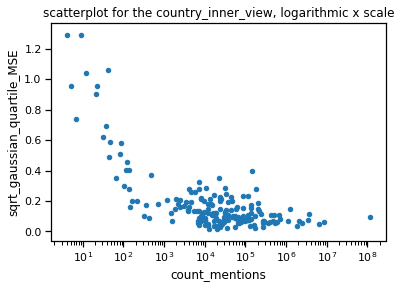

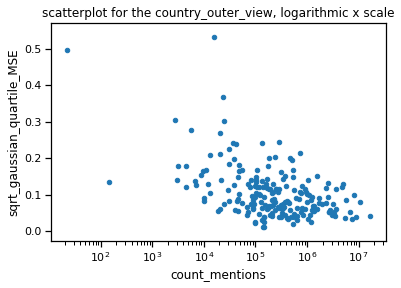

In [15]:
country_inner_view = add_sqrt_MSE_with_gaussian_quartiles(country_inner_view)
country_inner_view.plot(kind='scatter', x="count_mentions", y="sqrt_gaussian_quartile_MSE",
                       title="scatterplot for the country_inner_view, logarithmic x scale",
                       logx=True)

country_outer_view = add_sqrt_MSE_with_gaussian_quartiles(country_outer_view)
country_outer_view.plot(kind='scatter', x="count_mentions", y="sqrt_gaussian_quartile_MSE",
                       title="scatterplot for the country_outer_view, logarithmic x scale",
                       logx=True);

The bounds (95% confidence) obtained by bootstrapping are: (-3.9183068786965083, -3.880693474036577)
Those assuming a normal distribution are: (-3.9188436413882974, -3.8787580581669254)


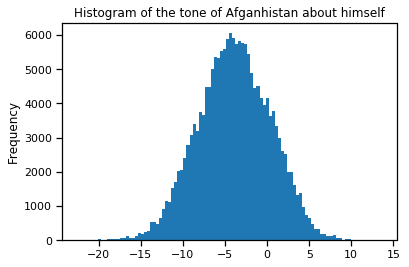

In [16]:
afghanistan_inner.tone.plot(kind='hist', bins=100, 
                            title="Histogram of the tone of Afganhistan about himself");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(afghanistan_inner.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(afghanistan_inner.tone)}")

The bounds (95% confidence) obtained by bootstrapping are: (-1.8908642246573695, -1.8012252105411772)
Those assuming a normal distribution are: (-1.8845573564774487, -1.8060942590777171)


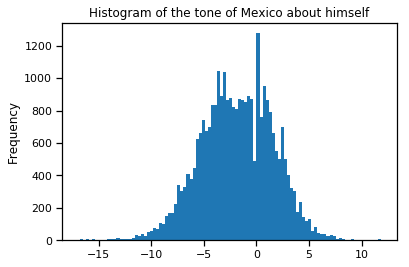

In [17]:
mexico_inner.tone.plot(kind='hist', bins=100, 
                            title="Histogram of the tone of Mexico about himself");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(mexico_inner.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(mexico_inner.tone)}")

The bounds (95% confidence) obtained by bootstrapping are: (-0.019279952221171442, 0.13092308571850833)
Those assuming a normal distribution are: (-0.018519413756928955, 0.13388806417709573)


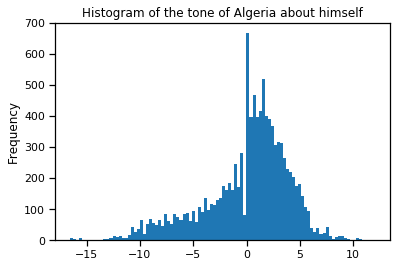

In [18]:
algeria_inner.tone.plot(kind='hist', bins=100, 
                            title="Histogram of the tone of Algeria about himself");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(algeria_inner.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(algeria_inner.tone)}")

The bounds (95% confidence) obtained by bootstrapping are: (-3.9117027258153545, -3.8662098475808726)
Those assuming a normal distribution are: (-3.9124579463617812, -3.862879912430102)


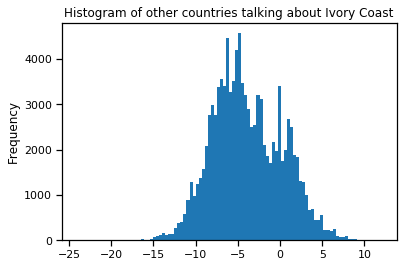

In [19]:
ivory_coast_outer.tone.plot(kind='hist', bins=100, 
                            title="Histogram of other countries talking about Ivory Coast");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(ivory_coast_outer.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(ivory_coast_outer.tone)}")

The bounds (95% confidence) obtained by bootstrapping are: (-1.3996424623700654, -1.3320938551657902)
Those assuming a normal distribution are: (-1.4029720472365965, -1.3325140314367512)


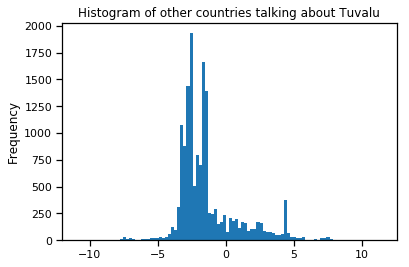

In [20]:
tuvalu_outer.tone.plot(kind='hist', bins=100, 
                            title="Histogram of other countries talking about Tuvalu");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(tuvalu_outer.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(tuvalu_outer.tone)}")

## 3. Study of chosen and representative cases

#### This corresponds to the deliverable of milestone 2 (some of the path we explored were not pursuied). For the analysis corresponding to milestone 3, see section 5.

#### Rapid data analisys of country_inner_view and country_outer_view
We can see from the following that the average tone is often negative and that it is a bit better for the inner view than the outer view. We can also check that the results makes sense, for example by checking that Pakistan mentions India in a negative way whereas other countries have better relations, like Germany and the US for example.

In [21]:
country_inner_view.describe()

,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone,sqrt_gaussian_quartile_MSE
count,183.000000,183.000000,1.830000e+02,1.830000e+02,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,179.000000
mean,-0.917556,3.372600,8.779737e+05,2.603750e+05,44.952189,-0.869825,4.388063,-2.941370,-0.687191,1.304337,0.189832
std,1.784584,0.907944,8.747310e+06,2.084731e+06,9.608140,1.788044,1.093489,2.024653,1.855807,1.866121,0.219170
min,-7.171489,0.000000,1.000000e+00,1.000000e+00,10.000000,-7.146625,0.000000,-7.885305,-7.604563,-6.357388,0.015745
25%,-2.023705,3.200463,4.322500e+03,4.203500e+03,41.013379,-1.930668,4.059330,-4.315440,-1.827605,0.408337,0.074864
50%,-0.893042,3.557885,2.181000e+04,1.628600e+04,44.187264,-0.831848,4.485309,-3.149606,-0.721371,1.344086,0.118729
75%,0.080816,3.870141,9.359050e+04,7.312200e+04,46.986793,0.164151,4.904782,-1.848100,0.536117,2.470856,0.203565
max,5.031447,5.283884,1.179173e+08,2.801146e+07,100.000000,5.031447,8.970664,5.031447,5.031447,6.077348,1.292983


In [22]:
print(f"number of positive avg_tones for inner_view {np.sum(country_inner_view.avg_tone >= 0)}")

number of positive avg_tones for inner_view 49


In [23]:
country_outer_view.describe()

,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone,sqrt_gaussian_quartile_MSE
count,201.000000,201.000000,2.010000e+02,2.010000e+02,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,-2.580441,3.586840,9.041930e+05,2.806251e+05,40.461573,-2.566839,5.053766,-4.925565,-2.537908,-0.168140,0.106074
std,1.290678,0.418709,1.958803e+06,6.362356e+05,4.680269,1.344607,0.681393,1.441747,1.409976,1.365804,0.072836
min,-5.976917,2.239949,2.200000e+01,1.600000e+01,29.164784,-6.011869,2.531634,-8.366534,-6.122449,-3.878583,0.011764
25%,-3.488626,3.381708,8.213900e+04,3.200200e+04,37.936310,-3.394280,4.641861,-5.906040,-3.424658,-1.096491,0.058304
50%,-2.474342,3.630566,2.151190e+05,7.300500e+04,39.908261,-2.492318,5.049215,-4.945055,-2.454780,0.000000,0.087230
75%,-1.631754,3.856826,7.597890e+05,2.434690e+05,41.951635,-1.580352,5.518754,-3.985507,-1.587302,0.731261,0.128650
max,0.847615,4.759866,1.683009e+07,6.566142e+06,71.612178,1.007224,6.854974,-0.643501,1.511335,3.475936,0.532463


In [24]:
print(f"number of positive avg_tones for outer_view {np.sum(country_outer_view.avg_tone >= 0)}")

number of positive avg_tones for outer_view 6


In [25]:
country_to_country_view[np.logical_and(country_to_country_view["mention_country"] == 'India', 
                       country_to_country_view["actor_country"] == 'Pakistan')]

,actor_country,mention_country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
224,Pakistan,India,-3.650736,3.489361,1355382,537509,40.550376,-3.759414,5.50043,-5.705706,-3.412969,-1.421801


#### Example of error to avoid with United Arab Emirates :

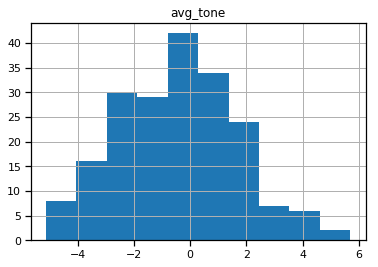

In [26]:
UAE = country_to_country_view[country_to_country_view["mention_country"] == 'United Arab Emirates']
UAE.hist('avg_tone');

We can see that the United Arab Emirates has an avg_tone distributed around zero. We could conclude that others countries have a neutral opinion of this country, but if we keep only the rows with more than one hundred citations:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19ab0cf8>]],
      dtype=object)

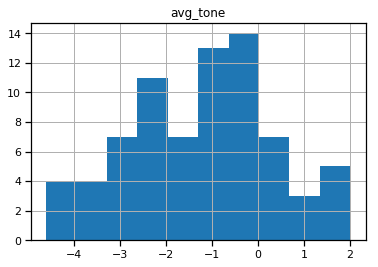

In [27]:
UAE_mentions =  UAE[UAE["count_mentions"] > 1000]
UAE_mentions.hist('avg_tone')

We can see that most of the countries have a negative opinion of the United Arab Emirates. This little example shows that we have to be very careful about our results and take precautions for the explanations.

#### Compares inner and outer view in a scatterplot. 
We could refine the following scatterplot by showing how to divide it into several countries, comment the results, ...

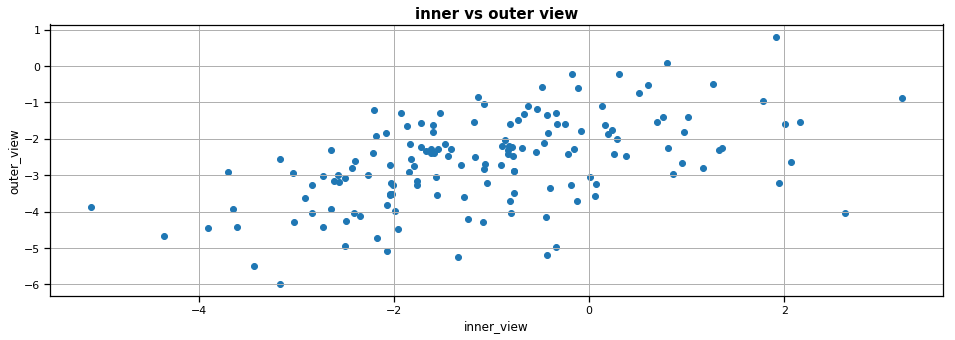

In [28]:
# comparing inner and outer view
country_inner_view = country_inner_view[country_inner_view["count_events"] > 1000]
country_outer_view = country_outer_view[country_outer_view["count_events"] > 1000]
inner_outer_view = country_inner_view.merge(country_outer_view, left_on="country", 
                                            right_on="country", suffixes=("_in", "_out"))
fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(x='avg_tone_in', y='avg_tone_out', data=inner_outer_view)
ax.set_title("inner vs outer view", fontsize=15, fontweight='bold')
ax.set_ylabel('outer_view')
ax.set_xlabel('inner_view')
ax.grid(True)

#### Separation into actor type example with the USA
We use here the USA as an example of what could be done with the country_to_type_view. For simplicity, we did not compute confidence intervals here but this could be done (assuming the repartition of the mean is normal as before). We can see for example that the US police forces (COP) are very unpopular from abroad, the same goes for the judiciary system (JUD) and the media (MED), whereas multi national corporation (MNC) and education (EDU) are not seen that badly.

In [29]:
country_to_type_USA = country_to_type_view[country_to_type_view.actor_country == "United States"]

# we will get the average tone towards actor types in the US and compare it with the national mean
count_mentions_per_actor_type = country_to_type_USA.groupby("actor_type").count_mentions.sum()
weighted_sum_avg_tone_actor_type = country_to_type_USA.groupby("actor_type").apply(
    lambda x: x.avg_tone * x.count_mentions).groupby("actor_type").sum()
concat = pd.concat([count_mentions_per_actor_type, weighted_sum_avg_tone_actor_type], axis=1)

national_mean = concat.sum()
national_mean = national_mean.loc[0] / national_mean.loc["count_mentions"]
print(f" the average tone nation-wide is {national_mean}")

 the average tone nation-wide is -2.728636659173831


In [30]:
concat = concat[concat.count_mentions > 1000000]
print("when dividing into actor types, we have:")
concat[0] / concat["count_mentions"]

when dividing into actor types, we have:


actor_type
COP   -5.903874
EDU   -1.594095
GOV   -2.184429
JUD   -5.472220
LEG   -1.824396
MED   -3.467980
MNC   -0.633202
dtype: float64

#### Separation into news sources example with the USA and China
We could use the average score from the medias of a country to another to see if medias from a country do not agree on the status of another one. We can see in this very basic example, that the view of big americans new about china varies, for example, we can see that "4-traders.com" usually has a positive tone about China since China is probably very interesting from a trading perspective. This is just a dummy example and there is probably nothing interesting to see here. Another interesting idea would be to compare the average tone of small news websites with the average tone of big news websites about a country.

In [31]:
USA_China = media_to_country_view[np.logical_and(media_to_country_view.source_country == "United States",
                                  media_to_country_view.actor_country == "China")]
USA_China[USA_China.count_mentions > 20000]

,actor_country,source_country,source_name,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
58952,China,United States,reuters.com,-2.152007,2.750651,138868,49885,41.727828,-2.167459,3.943870,-3.709949,-1.946472,-0.361011
282862,China,United States,yahoo.com,-2.143683,3.115891,182825,112022,41.631123,-2.169520,4.367902,-3.982301,-2.046036,-0.181818
461511,China,United States,bloomberg.com,-1.287174,2.120208,38476,23605,40.744360,-1.366140,2.947172,-2.628918,-1.203209,0.303644
557202,China,United States,blogspot.com,-1.857388,2.553935,22815,21431,37.500329,-1.707879,3.423856,-3.629032,-1.715511,-0.157580
659387,China,United States,nytimes.com,-2.289576,2.670952,22188,20716,39.835947,-2.364019,3.934759,-3.746398,-2.061856,-0.529101
672172,China,United States,businessinsider.com,-1.958092,2.619248,24087,23023,40.274007,-1.983223,3.727654,-3.438395,-1.792115,-0.296296
710515,China,United States,channelnewsasia.com,-2.485944,3.059054,44587,31201,42.125956,-2.575203,4.482945,-4.252199,-2.311248,-0.456621
895423,China,United States,iheart.com,-1.067503,3.691916,29592,896,44.465396,-1.086947,4.304979,-4.026846,-0.934579,1.351351
908162,China,United States,todayonline.com,-2.285084,2.900841,22506,20646,41.764418,-2.342175,4.113598,-3.906250,-2.055921,-0.424628
940014,China,United States,trust.org,-3.178125,2.867782,29598,19075,40.353740,-3.317386,4.637650,-4.809619,-2.873563,-1.190476


## 4. Presentation of the goals for the next milestone    
15/01:
    - deciding what to put on the poster  
21/01:
    - poster creation and presentation repetition  
    
The presentation should be organised as follow (subject to change):
    1. Global results
    2. Inner vs outer view interpretation
    3. Clustering

## 5. Data analysis corresponding to the data-story
#### these will be generated in the same order as they appear in the datastory except for the media analysis 

#### grouping the number of mentions a country gets from the rest of the world and himself into different size categories
In order to better understand our dataset, it’s important to take into account the count of mentions of each country. In fact we have to be very careful when we will conclude about a phenomenon because a small count of count_event for a country can lead us down to a wrong path.

In [32]:
values = country_outer_view.merge(country_inner_view, left_on="country", right_on="country",
                                 how='outer')
values.fillna(0, inplace=True)  # some countries do not have any mentions about themselves
values["total_count"] = values["count_mentions_x"] + values["count_mentions_y"]
values = values[["country", "total_count"]]

# we will group these values in different intervals
limits = [1e4, 1e5, 1e6]
counts = []

counts.append(np.sum(values.total_count < limits[0]))
for i in range(1,len(limits)):
    counts.append(np.sum(np.logical_and(values.total_count < limits[i],
                                        values.total_count > limits[i-1])))
counts.append(np.sum(values.total_count > limits[-1]))

desc = ["less than ten thousand", "between ten thousand and one hundred thousand",
    "between a hundred thousand and one million", "more than one million mentions"]

# we used a df here to save it as a csv and export it to plotly
final_count = pd.DataFrame(data={"nbr countries": counts, "desc": desc})
# final_count.to_csv(os.path.join(DATA_DIR, 'count_size_categories_mentions.csv'))
final_count

,nbr countries,desc
0,9,less than ten thousand
1,38,between ten thousand and one hundred thousand
2,104,between a hundred thousand and one million
3,47,more than one million mentions


see chart [here](https://plot.ly/~christophe.minutolo/24.embed)

In [33]:
values.sort_values(by="total_count", ascending=False).head(5)

,country,total_count
83,United States,134747353.0
140,United Kingdom,15341630.0
158,Australia,11875784.0
38,Russia,11251086.0
81,China,9539083.0


We can see that the number of mentions about the united states is very important, we will explore this further by looking at the graph structure of the mentions

#### graph visialisation
We will try to get insight about the number of mentions a country makes of another. We will thus not display self-eges, we will also limit ourselves to a small number of edges for visibility.

In [34]:
NUM_DISPLAYED_EDGES = 40
country_to_other_country = country_to_country_view[country_to_country_view.actor_country != \
                                                  country_to_country_view.mention_country]
edges_values = np.sort(country_to_other_country.count_mentions.values)
graph = country_to_other_country[country_to_other_country["count_mentions"] >= 
                                edges_values[edges_values.shape[0] - NUM_DISPLAYED_EDGES]].copy()

# so that they are displayed on two lines in the graph
graph["actor_country"] = graph["actor_country"].apply(lambda x: x.replace(' ', '\n'))
graph["mention_country"] = graph["mention_country"].apply(lambda x: x.replace(' ', '\n'))
graph.sort_values(by="count_mentions", ascending=False).head()

,actor_country,mention_country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
2554,Russia,United\nStates,-3.192588,2.717061,7210348,1552467,34.005404,-3.234261,4.410215,-4.855072,-3.022453,-1.385042
22852,United\nKingdom,United\nStates,-2.430599,3.688745,5199332,1559839,39.000022,-2.315606,5.078748,-4.882252,-2.277904,0.000000
13885,France,United\nStates,-3.135730,3.584924,4445363,1028751,37.329017,-3.127428,5.227597,-5.610561,-3.001464,-0.709220
10289,Syria,United\nStates,-4.666384,2.630926,4363773,910725,34.339758,-4.765086,5.127742,-6.341463,-4.621514,-2.922078
8490,China,United\nStates,-2.040634,2.979879,4361879,1250426,40.302753,-2.021240,4.151942,-3.739316,-1.990950,-0.169924


In [35]:
nx_graph = nx.from_pandas_edgelist(graph, target='actor_country', source='mention_country',
                        edge_attr=["count_mentions", "avg_tone"], create_using=nx.DiGraph())
print(nx.info(nx_graph))

Name: 
Type: DiGraph
Number of nodes: 34
Number of edges: 40
Average in degree:   1.1765
Average out degree:   1.1765


In [36]:
def print_nx_digraph(nx_graph, save=False, name="default.svg"):
    """
    print and maybe saves the given nx_graph
    
    :param nx_graph: the digraph as an nx_object
    :param save: wether to save it or not
    :param name: the name of the file the graph will be saved into
    """
    edge_size = nx.get_edge_attributes(nx_graph, "count_mentions")
    edge_color = nx.get_edge_attributes(nx_graph, "avg_tone")
    sizes = [edge_size[i] for i in nx_graph.edges()]
    max_sizes = max(sizes)
    sizes = [3*i/max_sizes for i in sizes]
    colors = [edge_color[i] for i in nx_graph.edges()]
    
    nx.draw_shell(nx_graph, with_labels=True, node_size=150, font_size=7, width=sizes ,
                   node_shape="h", node_color='w', linewidths=1, style='solid', arrow_style="->",
                  edge_cmap=cm.get_cmap("RdBu"), edge_vmin=-5, 
                  edge_vmax=5, edge_color=colors)  # edge_vmin and vmax chose so as to
    # have contrast
    if save:
        plt.savefig(os.path.join(GEN_DIR, name), bbox_inches='tight')

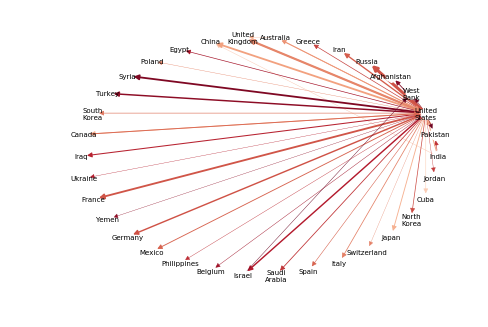

In [37]:
print_nx_digraph(nx_graph, save=False, name='network_US.svg')

We will now do the same as before but without the mentions written by the united states

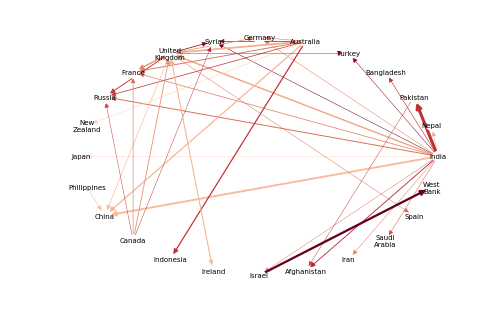

In [38]:
country_to_other_country_no_us = country_to_other_country[np.logical_and(country_to_other_country.mention_country !=
                        "United States", country_to_other_country.actor_country != "United States")]
edges_values = np.sort(country_to_other_country_no_us.count_mentions.values)
graph_no_us = country_to_other_country_no_us[country_to_other_country_no_us["count_mentions"] >= 
                                edges_values[edges_values.shape[0] - NUM_DISPLAYED_EDGES]].copy()

# so that they are displayed on two lines in the graph
graph_no_us["actor_country"] = graph_no_us["actor_country"].apply(lambda x: x.replace(' ', '\n'))
graph_no_us["mention_country"] = graph_no_us["mention_country"].apply(lambda x: x.replace(' ', '\n'))

nx_graph_no_us = nx.from_pandas_edgelist(graph_no_us, target='actor_country', source='mention_country',
                        edge_attr=["count_mentions", "avg_tone"], create_using=nx.DiGraph())

print_nx_digraph(nx_graph_no_us, save=False, name='network_no_US.svg')

#### Number of mentions
plotting the number of mentions for each country (either that the country made or about the country) in log scale

In [39]:
# adapted from https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
def plot_dendrogram(model, title, save_fig, **kwargs):
    """
    =========================================
    Plot Hierarachical Clustering Dendrogram 
    =========================================
    This example plots the corresponding dendrogram of a hierarchical clustering
    using AgglomerativeClustering and the dendrogram method available in scipy.
    """

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    fig, ax = plt.subplots()
    ax.set_title(title)
    dendrogram(linkage_matrix, orientation='right', **kwargs)
    if save_fig:
        plt.savefig(os.path.join(GEN_DIR, f"{title}.svg"), transparent=True, bbox_inches='tight')

In [40]:
def add_CI_to_DF(df, mean_col_name="avg_tone", std_col_name="std_tone", count_col_name="count_mentions", std_mean_col_name=None, alpha=0.05):
    """
    by the Continuous limit theorem, the mean of a R.V. is distributed as N(\mu, \sigma^2/n)
    We will compute the bounds and add them to the dataframe assuming the CLT holds even tough 
    n is finite
    
    :param df: the dataframe
    :param mean_col_name: the name of the column of df containing the mean of the data
    :param std_col_name: the name of the column of df containing the std of the data
    :param count_col_name: the name of the column of df containing the count of the data
    :param std_mean_col_name: the std of the mean (if this is set, std_col_name and count_col_name are not used)
    :param alpha: the parameter alpha corresponding to the CI (ex: 0.05 for 95% CI)
    """

    interval = norm.interval(1-alpha)
    if std_mean_col_name is None:
        mean_std = df[std_col_name] / (df[count_col_name]**0.5)
    else:
        mean_std = df[std_mean_col_name]
    df[mean_col_name + "_low_CI"] = interval[0]*mean_std + df[mean_col_name]
    df[mean_col_name + "_high_CI"] = interval[1]*mean_std + df[mean_col_name]

In [41]:
# converts a matplotlib color scale to a plotly one
# https://plot.ly/python/matplotlib-colorscales/
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = (np.array(cmap(k*h)[:3])*255).astype(np.uint8)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

In [42]:
def export_map_to_plotly(df, data_col_name, file_name, country_codes=country_codes, 
                     country_col_name="country"):
    """
    generates a plotly graph from the given dataframe
    
    :param df: the dataframe containing the data
    :param data_col_name: the name of the column containing the data
    :param file_name: name of the output plotly file
    :param country_codes: the df that contains the mapping from country names to country codes
    :param country_col_name: the name of the column of df that contains the country names
    """
    country_codes = country_codes[country_codes.count_mentions > MIN_CONSIDER]
    output = df.merge(country_codes, left_on=country_col_name, right_on="country_name",
                          suffixes=('',''))
    output["text"] = output.apply(lambda x: f"{x.country} <br>" + 
    (f"95% CI: [{x[data_col_name + '_low_CI'] :0.3f}, {x[data_col_name + '_high_CI']: 0.3f}] <br>"
    if x.count_mentions > MIN_CI else "") + f"{x.count_mentions: .0E} datapoints", axis=1)
    data = [ dict(
            type = 'choropleth',
            locations = output.country_ISO,
            z = np.round(output[data_col_name], 3),
            text = output.text,
            autocolorscale = True,
            reversescale = True,
            colorbar = dict(
                autotick = False,
                title = 'FILL IN'),
          ) ]

    layout = dict(
        title = 'FILL IN',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = dict(data=data, layout=layout)
    py.iplot(fig, validate=False, filename=file_name)

In [43]:
def export_maps_locally(dfs, data_col_name, frame_names, title, colorbar_title, colorbar_scale,
                          country_codes=country_codes, country_col_name="country", show_mentions=False,
                          colorscale=None, file_name="default.html", export=False):
    """
    generates a plotly graph from the given dataframes, we take a list of dataframes rather than
    a single one whose values we can divide because we want to display information from different
    dataframes (ex: outer_view and outer_type_view), this file saves the plot locally rather than
    using the plotly website because the website do not work with several frames
    
    :param dfs: the dataframe containing the data all in the same format
    :param data_col_name: the name of the column containing the data
    :param frame_names: name of the different frames
    :param title: the title of the file
    :param colorbar_title: the title of the colorbar
    :param colorbar_scale: a pair (zmin, zmax) containing the min and max values of the colorbar
    :param country_codes: the df that contains the mapping from country names to country codes
    :param country_col_name: the name of the column of df that contains the country names
    :param show_mentions: if set to true, we never compute CI and do not show value attribute on hover
    :param colorscale: the corresponding matplotlib colorscale, None if we have to use
    the default color scale
    :param file_name: name of the output plotly file
    :param export: wether to save the graph as html or to display the file
    """
    outputs = []
    for df in dfs:
        if not show_mentions:  # we filter out countries with less than 200 occurences
            df = df[df.count_mentions > MIN_CONSIDER]
        output = df.merge(country_codes, left_on=country_col_name, right_on="country_name",
                              suffixes=('',''))
        output["text"] = output.apply(lambda x: f"{x.country} <br>" + 
        (f"95% CI: [{x[data_col_name + '_low_CI'] :0.3f}, {x[data_col_name + '_high_CI']: 0.3f}] <br>"
        if x.count_mentions > MIN_CI and not show_mentions else "") 
                                      + f"{x.count_mentions: .0E} datapoints", axis=1)
        outputs.append(output)
    
    data = [dict(
            type = 'choropleth',
            autocolorscale = True,
            zmin = colorbar_scale[0],
            zmax = colorbar_scale[1],
            hoverinfo = "text" if show_mentions else "z+text",
            reversescale = True,
            colorbar = dict(
                title = colorbar_title))]
    
    if colorscale is not None:
        data[0]["colorscale"] = matplotlib_to_plotly(colorscale, 8)
        data[0]["autocolorscale"] = False
    
    frames = [dict(
                name = frame_name,
                data = [dict(
                        type = 'choropleth',
                        locations = output.country_ISO,
                        z = np.round(output[data_col_name], 3),
                        text = output.text)],
            ) for output, frame_name in zip(outputs, frame_names)]

    layout = dict(
        title = title,
        left = 0,
        paper_bgcolor = 'rgba(0, 0, 0, 0)',
        geo = dict(
            showframe = True,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator')),
        sliders = [dict(
                    active = 1,
                    steps = [dict(label = frame_name,
                                  args = [[frame_name]],
                                  method = 'animate') for frame_name in frame_names])],
    )


    fig = dict(data=data, layout=layout, frames=frames)
    if export:
        plot(fig, filename=os.path.join(GEN_DIR, file_name), validate=False)
    else:
        iplot(fig, validate=False)

In [44]:
frame_names = ["mentions about country", "mentions from country"]
dfs = []

dfs.append(country_to_country_view.groupby("actor_country").agg({"count_mentions": "sum"}))
dfs.append(country_to_country_view.groupby("mention_country").agg({"count_mentions": "sum"}))

# renaming columns adding log scale:
for df in dfs:
    df.reset_index(inplace=True)
    df.columns = ["country", "count_mentions"]
    df["log_count_mentions"] = np.log10(df["count_mentions"])

export_maps_locally(dfs, "log_count_mentions", frame_names,
                    "total number of mentions about/from a country", 
                    "log in base 10 of <br> the number of mentions", (2, 8),
                    colorscale = cm.get_cmap("YlOrBr_r"),
                    show_mentions=True, file_name="count_mentions.html", export=False)

# Regarding the fact some European countries do not have any mentions about them (ex: Romania)
# it means that (a): GDELT did not use the 3 letters ISO code "ROM" for Romania
# (b): there is no mention about Romanian event in GDELT
# (c): we made a mistake somewhere (but we really seached it and did not find anything)

see map [here](https://gossipworld.github.io/plots/count_mentions.html)

In [45]:
# we can already add confidence intervals since these df won't be grouped
add_CI_to_DF(country_inner_view)
add_CI_to_DF(country_outer_view)
add_CI_to_DF(country_inner_type_view)
add_CI_to_DF(country_outer_type_view)

#### Countries ranking
First, we simply save the outer views of each country. We then try to take into account the score of a country to weight the tone he uses to talk about other countries, unfortunately, most of the countries scores are negative, which means that a country referenced by a lot of other countries in a negative way will be positively impacted (e.g. USA). A solution to this problem would be to change the avg_tones (uniformy while modifying them as little as possible) so that all the countries are positively coted and to sort that data.

In [46]:
# export_map_to_plotly(country_outer_view, "avg_tone", "outer_view_base_plot")  # uncomment to export to plotly

see map [here](https://plot.ly/~christophe.minutolo/12.embed)

In [47]:
# decreasing the weight of a country with bad reputation to compute the reputation of another 
# country
c_to_c_transition = country_to_country_view[["actor_country", "mention_country", "avg_tone", 
                                              "count_mentions", "avg_weighted_tone"]]
# other columns cannot be splitted from country to country

c_to_c_transition = c_to_c_transition[c_to_c_transition.actor_country !=
                                             c_to_c_transition.mention_country]


# get the count of articles for each actor_country and weight avg_tone and avg_weighted_tone by 
# this, i.e. avg_tone = avg_tone * count / (sum count for actor_country)
counts = c_to_c_transition.groupby("actor_country")["count_mentions"].agg("sum")
c_to_c_transition = c_to_c_transition.merge(counts.to_frame(), left_on="actor_country",
                                            right_on="actor_country")
c_to_c_transition.avg_tone = (c_to_c_transition.avg_tone + 7)* c_to_c_transition.count_mentions_x / \
                            c_to_c_transition.count_mentions_y
# the value of 7 is chosen (by trial and error) so that it is as small as possible (the bigger 
# this value, the less tones are different and the the more "uniform" the data becomes) and that
# there are no countries with a negative score (being criticized by these countries would mean
# we are good and initially, nearly all countries were negatives)
c_to_c_transition = c_to_c_transition.drop(["count_mentions_x", "count_mentions_y"], axis=1)


# putting the country to country transitions in the form of a np matrix (graph transition matrix
# ) instead of using the power method, we will compute teh eigenvalues/eigenvectors by
# using numpy "eig" function
index_to_country = np.unique(country_to_country_view.actor_country.values)
country_to_index = {country: index for index, country in enumerate(index_to_country)}

transition_matrix = np.zeros((index_to_country.shape[0], index_to_country.shape[0]))
for row in c_to_c_transition.itertuples(index=False):
    if row.mention_country in country_to_index:  # we do not take the country that don't have
        # mentions from other countries into account
        transition_matrix[country_to_index[row.actor_country],
                      country_to_index[row.mention_country]] = row.avg_tone

eig_val, eig_vec = np.linalg.eig(transition_matrix)

# get the biggest read eigenvalue associated with a read eigenvector
eig_vec = eig_vec[:, np.isreal(eig_val)]
eig_val = eig_val[np.isreal(eig_val)].real
real_eig_vec = np.sum(np.iscomplex(eig_vec), 0) == 0  # real eigenvectors
eig_val = eig_val[real_eig_vec]
eig_vec = eig_vec[:, real_eig_vec].real

max_eig_val_idx = np.argmax(eig_val)
eig_vec = eig_vec[:, max_eig_val_idx]
eig_val = eig_val[max_eig_val_idx]

country_view = pd.DataFrame(data=eig_vec, index=index_to_country, columns=["avg_tone_graph"])

In [48]:
# compare both rankings, we only compute the ranking for the 40 biggest countries
country_view = country_view.merge(country_outer_view[country_outer_view.count_mentions > 1e6], left_index=True, right_on="country")
country_view = country_view[["country", "avg_tone", "avg_tone_graph"]]

# we will use the indexes to get the rankings
country_view = country_view.sort_values(by="avg_tone", ascending=False).reset_index()
country_view["normal_ranking"] = country_view.index + 1
country_view = country_view.sort_values(by="avg_tone_graph", ascending=False).reset_index()
country_view["graph_ranking"] = country_view.index + 1
country_view["places_won_with_graph"] = country_view["normal_ranking"] - country_view["graph_ranking"]
country_view = country_view[["country", "normal_ranking", "graph_ranking", "places_won_with_graph"]]
country_view = country_view.sort_values(by="places_won_with_graph", ascending=False)

In [49]:
country_view.head(10)

,country,normal_ranking,graph_ranking,places_won_with_graph
37,Nigeria,40,38,2
8,Poland,11,9,2
21,North Korea,23,22,1
31,Belgium,33,32,1
19,Malaysia,21,20,1
25,Philippines,27,26,1
17,Germany,19,18,1
16,France,18,17,1
15,Mexico,17,16,1
1,Ireland,3,2,1


In [50]:
country_view.tail(10)

,country,normal_ranking,graph_ranking,places_won_with_graph
39,Afghanistan,39,40,-1
38,Yemen,38,39,-1
5,China,5,6,-1
22,Greece,22,23,-1
9,Switzerland,9,10,-1
20,Russia,20,21,-1
10,United States,10,11,-1
26,Thailand,26,27,-1
32,Egypt,32,33,-1
18,Iran,16,19,-3


#### Inner - Outer View and relation with reporters without border country index
Computes the difference between the inner and outer view for each country, we tried with different actor types but finally kept using all of the types at once, change "selected_type" to another value and re-run the next cells to try other possibilities.

We also tried to compare the difference between both views with the [Reporters without borders 2016 World Press Freedom Index](https://rsf.org/en/ranking/2016#) but the results were not that conclusive so we did not show it in the data story.

REMARK: in the following, all of the plots are represented using a diverging scale, in most cases, the value of the center of the diverging doesn't have a particular meaning, however, using these blue-red scales allow for a much better interpretation of the opinions (seen positively-negatively). Additionnally, blue and red are naturally used to show approval/disaproval, thus we kept these (altough we shouldn't by strictly following theory).

In [51]:
cols_to_keep = ["country", "avg_tone", "std_tone", "count_mentions"]

selected_type = "ALL"

if selected_type == "ALL":
    diff_in_out = country_inner_view[cols_to_keep].merge(country_outer_view[cols_to_keep], 
        right_on="country", left_on="country")

else:
    diff_in_out = country_inner_type_view[country_inner_type_view.actor_type == selected_type]\
        [cols_to_keep].merge(country_outer_type_view[country_outer_type_view.actor_type \
        == selected_type][cols_to_keep], right_on="country", left_on="country")


diff_in_out["difference"] = diff_in_out["avg_tone_x"] - diff_in_out["avg_tone_y"]
diff_in_out["count_mentions"] = np.minimum(diff_in_out.count_mentions_x, 
                diff_in_out.count_mentions_y)  # we take the minimum between inner and
# outer count_mentions as number of count_mentions for the difference

# compute the confidence intervals
# std_mean(inner-outer) = sqrt(std_mean(inner)^2 + std_mean(outer)^2) -- assuming independence 
diff_in_out["std_diff"] = (diff_in_out.std_tone_x**2 / diff_in_out.count_mentions_x + \
                          diff_in_out.std_tone_y**2 / diff_in_out.count_mentions_y) ** 0.5
add_CI_to_DF(diff_in_out, mean_col_name="difference", std_mean_col_name="std_diff")

In [52]:
# export_map_to_plotly(diff_in_out, "difference", "difference_plot")  # uncomment to export to plotly

see map [here](https://plot.ly/~christophe.minutolo/10.embed)

In [53]:
diff_in_out = diff_in_out.merge(r_w_b_2016, left_on="country", right_on="name")

,difference,avg_tone_x,avg_tone_y,score
difference,1.000000,-0.212787,-0.659119,0.377836
avg_tone_x,-0.212787,1.000000,0.875068,-0.450927
avg_tone_y,-0.659119,0.875068,1.000000,-0.534222
score,0.377836,-0.450927,-0.534222,1.000000


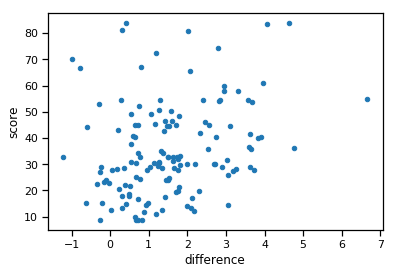

In [54]:
# the linear correlation is quite high when selection "GOV" or "POL" but the plots don't look
# much more appealing
diff_in_out.plot.scatter(x="difference", y="score")
diff_in_out.head()[["difference", "avg_tone_x", "avg_tone_y", "score"]].corr()

#### Analyzing the influence of actor types
plot the outer view for the main actor types in a worldmap. This allows to see what actor types are popular and how they are perceived through the different countries.

In [55]:
ACTOR_TYPES = ["GOV", "MED", "COP", "MNC", "JUD", "MIL", "EDU", "ELI"]
ACTOR_TYPES_DESCRIPTION = {"GOV": "Government", "MED": "Media", "COP": "Police" , 
                           "MNC": "Big Corporations", "JUD": "Judiciary", "MIL": "Military",
                           "EDU": "Education", "ELI": "Celebrities", "?": "Unknown"}
country_outer_type_view = country_outer_type_view[country_outer_type_view.actor_type.apply(
    lambda x: x in ACTOR_TYPES)]

# building list of dfs (one df per actor type + one for all of them) 
dfs = [country_outer_type_view[country_outer_type_view.actor_type == i] for i in ACTOR_TYPES]
dfs.append(country_outer_view)
dfs_names = [ACTOR_TYPES_DESCRIPTION[i] for i in ACTOR_TYPES] + ["all types"]

In [56]:
export_maps_locally(dfs, "avg_tone", dfs_names, 
                      title="Opinion of the rest of the world on a given country", 
                      colorbar_title="average tone", 
                      colorbar_scale=(-7,1),
                      file_name="outer_opinion_by_type.html", export=False)

see map [here](https://gossipworld.github.io/plots/outer_opinion_by_type.html)

#### clustering with or without actor_types
The clustering is done only with the biggest 40 countries to remove noise generated by minor countries (both for number of elements and number of dimensions). This is also a way to insure that we won't consider unreliable (only few mentions) columns too much. We use hierarchical clustering to identify the clusters (KMeans and DBScan were also tried).

In [57]:
def get_clustering_matrix(to_cluster, countries, cluster_on_popularity,
                          country_codes=country_codes):
    """
    returns the matrix used for clustering
    
    :param to_cluster: a df containing the countries to cluster from
    :param countries: list of countries to cluster from
    :param cluster_on_popularity: wether we cluster on the way we are seen by other countries
    or on the way we see other countries
    :param country_codes: the df that contains the mapping from country names to country codes
    """
    to_cluster = to_cluster[["actor_country", "mention_country", "avg_tone"]]
    to_cluster = to_cluster.set_index(["actor_country", "mention_country"])  # so that access is fast
    opinions = np.zeros((countries.shape[0], countries.shape[0]))  # if there are no mentions about
    # that country, the count should be of 0
    for i in range(opinions.shape[0]):
        for j in range(opinions.shape[0]):
            try:
                elem = to_cluster.loc[countries[i], countries[j]]  # the way j talks about i
                opinions[i,j] = elem["avg_tone"] 
            except KeyError as e:
                pass  # in this case we leave the default value in the array since there is no mention
    
    if not cluster_on_popularity:  # in that case categorize a country by the way he talk about others
        opinions = np.transpose(opinions)  
        
    return opinions

In [58]:
def compute_dendrogram(selected_type, countries, cluster_on_popularity, save_fig,
                      country_to_country_view=country_to_country_view, 
                      country_to_type_view=country_to_type_view):
    """
    clusters the given data and shows the corresponding dendrogram
    
    :param countries: the countries to cluster on
    :param selected_type: the actor type to cluster on or all
    :param cluster_on_popularity: wether we cluster on the way we are seen by other countries
    or on the way we see other countries
    :param save_fig: wether we save teh figure or not
    :param country_to_country_view: the df to use if selected_type is ALL
    :param country_to_type_view: the df to use if selected_type is not ALL
    """
    # only uses mentions where actor_type is selected_type
    title = "Dendrogram of the biggest countries " + ("by popularity" if cluster_on_popularity else "by opinion")
    if selected_type == "ALL":
        title += " on all actor types"
        to_cluster = country_to_country_view[country_to_country_view.apply(lambda x: 
                x.actor_country in countries and x.mention_country in countries, axis = 1)].copy()
    else:
        title += f" on {ACTOR_TYPES_DESCRIPTION[selected_type]}"
        to_cluster = country_to_type_view[country_to_type_view.apply(lambda x: x.actor_country 
            in countries and x.mention_country in countries and 
                                            x.actor_type == selected_type , axis = 1)].copy()
    
    countries = np.intersect1d(to_cluster.actor_country.unique(), to_cluster.mention_country.unique())
    opinions = get_clustering_matrix(to_cluster, countries, cluster_on_popularity=cluster_on_popularity)
    model = AgglomerativeClustering(n_clusters=13, affinity="l1", linkage="average")  # uses l1
    # norm because l2 norm is more sensible to big variations than to small ones

    clusters = model.fit_predict(opinions)
    plot_dendrogram(model, title=title, save_fig=save_fig, labels=countries)

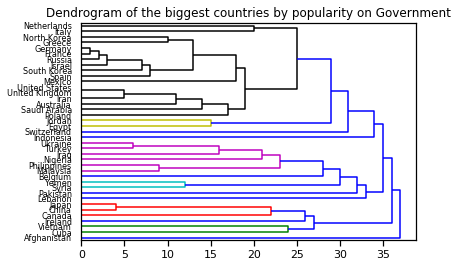

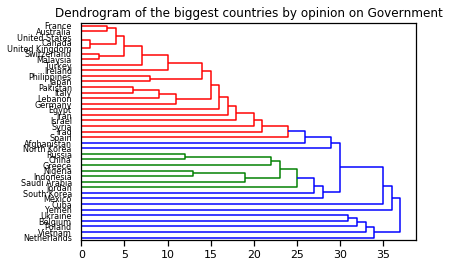

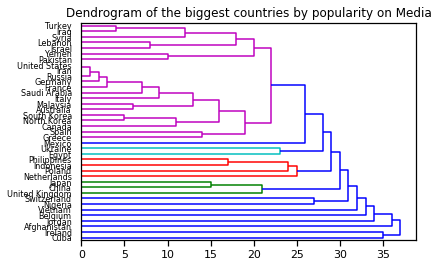

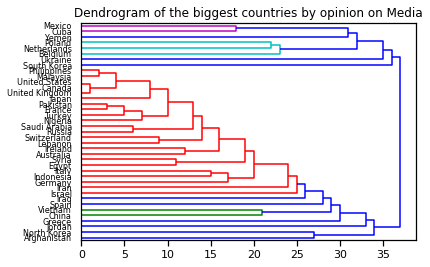

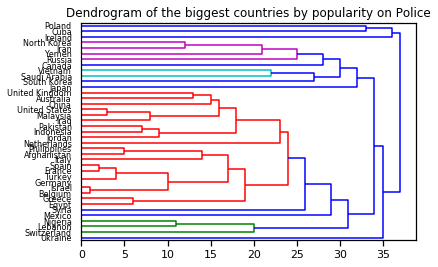

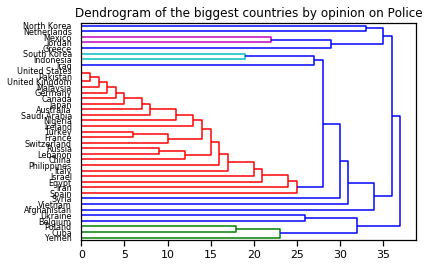

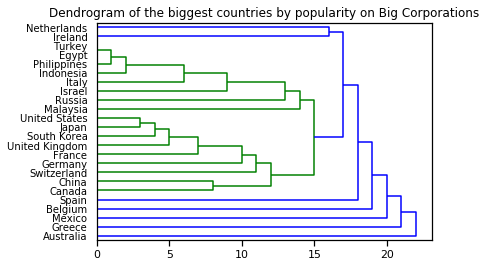

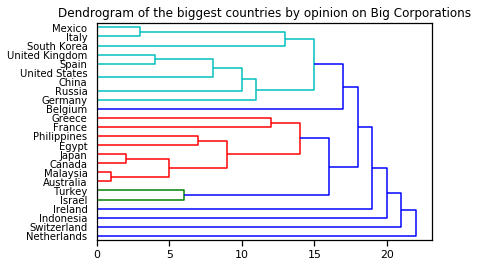

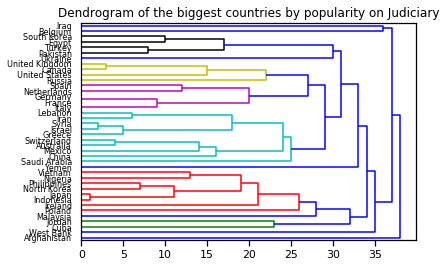

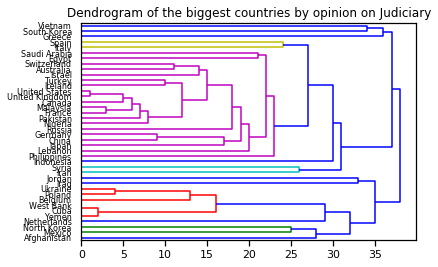

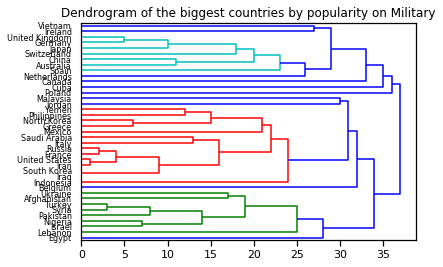

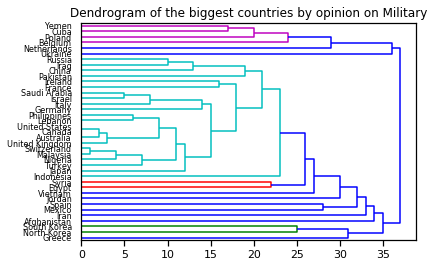

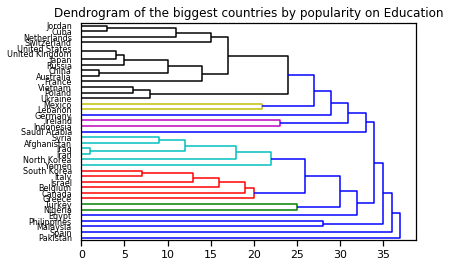

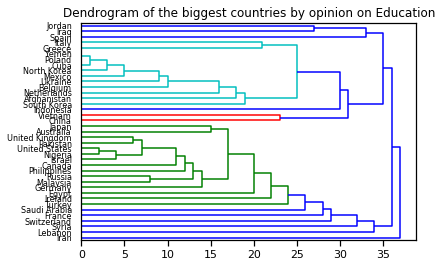

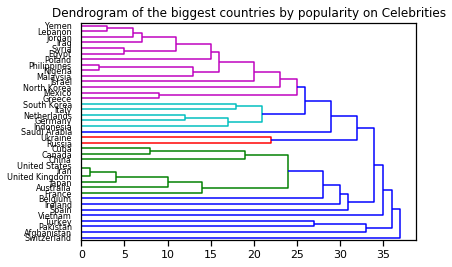

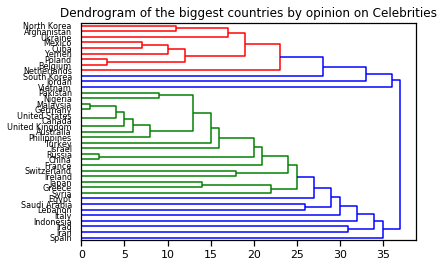

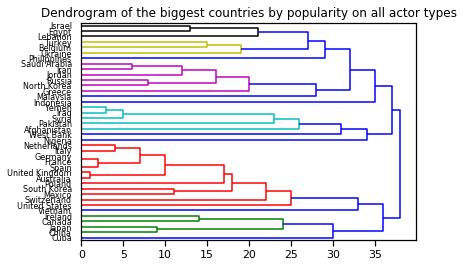

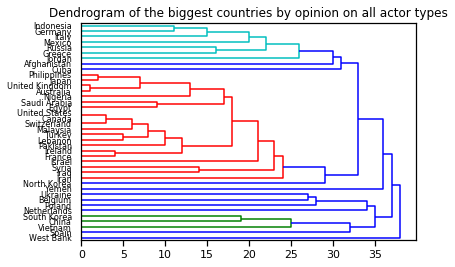

In [59]:
# taking the biggest countries in term of references
countries = list(country_outer_view.sort_values(by="count_mentions", 
                                                    ascending=False).head(40).country)

for i in ACTOR_TYPES + ["ALL"]:
    for j in [True, False]:
        compute_dendrogram(i, countries, cluster_on_popularity=j, save_fig=False)

#### Inner media variance
We will sort sources of each country by importance (growing number of news) and group progressively the consecutive sources to form groups that have the same count of mentions but that contains news sources of very different sizes. Then we will compute the outer view (and inner view as well) of each country by separating the different medias according to their size groups.

In [60]:
def get_source_importance(ser, nbr_clutsers):
    """
    given a serie containing the news sources of a country sorted by number of mentions and
    their number of mentions,
    return a label(0 to nbr_clutsers-1) for each of these sources so that each label contains
    as much mentions and that a smaller label contains smaller sources
    """
    cumsum = ser.cumsum()
    total_nbr_mentions = cumsum.tail(1)
    offsets = np.array([i * total_nbr_mentions/nbr_clutsers for i in range(nbr_clutsers)]).flatten()
    # lower bound for each cluster
    return cumsum.apply(lambda x: np.searchsorted(offsets, x) - 1) # offset in list

In [61]:
def compute_count_mean_std_from_subsets(df):
    """
    compute the count, mean and std on all the rows of the df having that each row contains 
    the count of elements and the std, using the folliwing:
    count_mentions_all = sum count_mentions
    avg_tone_all = avg_tone weighted by num_mentions
    std_tone_all = sqrt(1/(n-1) (sum_{i in subsets} (n_i-1)*std_i^2 + n_i*(mean_i - mean_all)^2 )
    n-1 because stddev is the unbiased variance estimator
    
    :param df: the dataframe
    """
    output = df[["count_mentions", "avg_tone", "std_tone"]].sum()
    output["avg_tone"] = (df["count_mentions"] * df["avg_tone"]).sum() / output["count_mentions"]
    if output["count_mentions"] == 1:
        output["std_tone"] = 0
    else:
        output["std_tone"] = (((df["count_mentions"] - 1) * df["std_tone"]**2 + \
                        df["count_mentions"] * (df["avg_tone"] - output["avg_tone"])**2).sum() \
                             / (output["count_mentions"] - 1))**0.5
    return output  

In [62]:
NBR_CLUSTERS = 3

if NBR_CLUSTERS == 2:
    frame_names = ["small medias", "big medias"]
elif NBR_CLUSTERS == 3:
    frame_names = ["small medias", "medium medias", "big medias"]
else:
    frame_names = [f"cluster {i}" for i in range(NBR_CLUSTERS)] 

# classifying te news into different clusters
source_cluster = media_to_country_view.groupby(["source_country",
                                            "source_name"]).agg({"count_mentions": "sum"})
source_cluster = source_cluster.sort_values(["source_country", "count_mentions"])
source_cluster["cluster"] = source_cluster.groupby("source_country").count_mentions.apply(
    lambda x: get_source_importance(x, NBR_CLUSTERS))
source_cluster = source_cluster.reset_index()

# computing the count of mentions, mean and std for each triple (source country, actor country,
# source_size)
news_to_country = media_to_country_view.merge(
    source_cluster[["source_country", "source_name", "cluster"]], 
    left_on=["source_name", "source_country"], right_on=["source_name", "source_country"],
    suffixes=('',''))
news_to_country = news_to_country.groupby(["actor_country", "source_country", 
            "cluster"]).apply(lambda x: compute_count_mean_std_from_subsets(x)).reset_index()

In [63]:
# computing the inner view from the country to country view
inner_cluster = (news_to_country[news_to_country.apply(lambda x: x.actor_country ==
        x.source_country, axis=1)])[["actor_country", "cluster", "avg_tone",
                                     "std_tone", "count_mentions"]]
inner_cluster.rename(columns={"actor_country": "country"}, inplace=True)

# do not show countries that do not have the min consider in all the clusters
inner_cluster = inner_cluster.groupby("country").filter(lambda x: x.count_mentions.min()\
        > MIN_CONSIDER and x.count_mentions.count() == NBR_CLUSTERS)
inner_all_clusters = country_inner_view[country_inner_view.country.isin(inner_cluster.country)]

add_CI_to_DF(inner_cluster)

# list of inner cluster for each cluster
inner_clusters = [inner_cluster[inner_cluster.cluster == i] for i in range(NBR_CLUSTERS)]

export_maps_locally(inner_clusters + [inner_all_clusters], "avg_tone", frame_names + ["all medias"], 
                    title="inner opinion for different size of medias", 
                    colorbar_title="average tone",
                    colorbar_scale=(-5,2),
                    file_name="media_inner.html", export=False)

see map [here](https://gossipworld.github.io/plots/media_inner.html)

In [64]:
# computing the outer view from the country to country view
outer_cluster = (news_to_country[news_to_country.apply(lambda x: x.actor_country !=
        x.source_country, axis=1)])[["actor_country", "cluster", "avg_tone",
                                     "std_tone", "count_mentions"]]
outer_cluster = outer_cluster.groupby(["actor_country", "cluster"]).apply(
    lambda x: compute_count_mean_std_from_subsets(x)).reset_index()

outer_cluster.rename(columns={"actor_country": "country"}, inplace=True)

# do not show countries that do not have the min consider in all the clusters
outer_cluster = outer_cluster.groupby("country").filter(lambda x: x.count_mentions.min()\
        > MIN_CONSIDER and x.count_mentions.count() == NBR_CLUSTERS)
outer_all_clusters = country_outer_view[country_outer_view.country.isin(outer_cluster.country)]

add_CI_to_DF(outer_cluster)

# list of outer cluster for each cluster
outer_clusters = [outer_cluster[outer_cluster.cluster == i] for i in range(NBR_CLUSTERS)]


export_maps_locally(outer_clusters + [outer_all_clusters], "avg_tone", frame_names + ["all medias"], 
                    title="outer opinion for different size of medias", 
                    colorbar_title="average tone",
                    colorbar_scale=(-7,1),
                    file_name="media_outer.html", export=False)

see map [here](https://gossipworld.github.io/plots/media_outer.html)

In [65]:
source_cluster[source_cluster.source_country == "Belgium"].sort_values(
    by="count_mentions", ascending=False).reset_index().head(5)

,index,source_country,source_name,count_mentions,cluster
0,966,Belgium,paneuropeannetworks.com,9368,2
1,965,Belgium,brusselstimes.com,6328,2
2,964,Belgium,deredactie.be,5480,1
3,963,Belgium,ec.europa.eu,4695,1
4,962,Belgium,investineu.com,3164,1


In the following, we will assess wether the fact that small medias are much more positive about other countries comes from a different repartition between the actor types (some actor types are much more popular than others, so that could lead to a simpson paradox) or of an actor type independent trend.

In [66]:
def get_error_bars(df, size_group, nbr_groups):
    """
    get error bars for each groups, since seaborn/matplotlib cannot display error
    bars for each bar for only for each x, we will use the biggest error for each group,
    in our case this is not a problem since the errors are quite small
    
    :param df: the df containing the errors (soted by groups)
    :param size_group: the size of a group
    :param nbr_groups: the number of groups (size_group*nbr_groups must be equal to the df length)
    """
    errors = np.zeros((2,nbr_groups))
    lower_errors = (df["avg_tone"] - df["avg_tone_low_CI"]).values
    upper_errors = (df["avg_tone_high_CI"] - df["avg_tone"]).values
    
    for i in range(nbr_groups):
        errors[0,i] = np.max(lower_errors[size_group*i:size_group*(i+1)])
        errors[1,i] = np.max(upper_errors[size_group*i:size_group*(i+1)])
        
    return errors
    

In [67]:
add_CI_to_DF(type_repartition)

agg_type_rep = type_repartition.groupby(["type", "cluster"]).agg({"avg_tone": "mean", 
    "count_mentions": "sum", "avg_tone_low_CI": "mean", "avg_tone_high_CI": "mean"})\
.reset_index()  # assuming independence btw RV to compute the CI

agg_type_rep["type_count_mentions"] = agg_type_rep.groupby("type").count_mentions.\
transform(sum)  # so that we can order by the most common types later on

agg_type_rep["cluster_count_mentions"] = agg_type_rep.groupby("cluster").count_mentions.\
transform(sum)  # we compute the proportion of each type in each cluster

agg_type_rep["prop_type_in_cluster"] = agg_type_rep.count_mentions / agg_type_rep.cluster_count_mentions

agg_type_rep = agg_type_rep.sort_values(by=["type_count_mentions", "cluster"], ascending=[False, True])
agg_type_rep_head = agg_type_rep[["type", "cluster", "avg_tone", "avg_tone_low_CI",
              "avg_tone_high_CI", "prop_type_in_cluster"]].head(24)

agg_type_rep_head["type"] = agg_type_rep_head["type"].apply(lambda x: ACTOR_TYPES_DESCRIPTION[x])
agg_type_rep_head["media size"] = agg_type_rep_head["cluster"].apply(
    lambda x: "small" if x == 0 else ("medium" if x==1 else "big"))
agg_type_rep_head

,type,cluster,avg_tone,avg_tone_low_CI,avg_tone_high_CI,prop_type_in_cluster,media size
0,Unknown,0,-1.824854,-1.872394,-1.777313,0.825984,small
1,Unknown,1,-2.827882,-2.875846,-2.779919,0.813551,medium
2,Unknown,2,-2.818038,-2.861166,-2.774911,0.808234,big
30,Government,0,-1.958735,-2.101121,-1.816349,0.083954,small
31,Government,1,-2.842114,-2.976312,-2.707917,0.101354,medium
32,Government,2,-2.695498,-2.810955,-2.580042,0.103627,big
60,Military,0,-2.509531,-3.018894,-2.000169,0.008920,small
61,Military,1,-3.389665,-3.951258,-2.828072,0.010854,medium
62,Military,2,-3.426137,-3.916229,-2.936045,0.011266,big
57,Media,0,-2.891327,-3.394742,-2.387912,0.008530,small


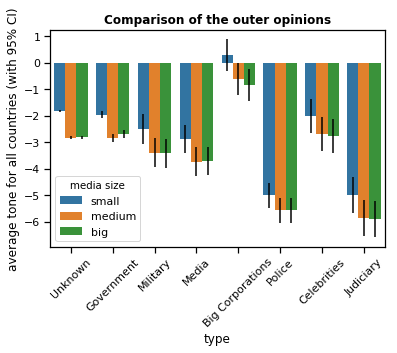

In [68]:
fig1, ax = plt.subplots()
ax.set_title(f'Comparison of the outer opinions',
             fontweight='bold')

sns.barplot(x="type", y="avg_tone", hue="media size", 
            data=agg_type_rep_head, yerr=get_error_bars(agg_type_rep_head, 3, 8))
# the huge size of the CI can be explained by the fact we weigh each country equally, so the
# small countries have here the same importance as the USA

plt.xticks(rotation=45)
ax.set_ylabel('average tone for all countries (with 95% CI)');

# fig1.savefig(os.path.join(GEN_DIR, "outer_opinion_by_type.svg"), transparent=True, bbox_inches='tight')

Another confusion factor that might arise is the country the news talks about, for example maybe small news talks more about friendly countries whereas medium/big news talk more about "ennemy" countries. 

In [69]:
# link country to country (when both country are different) with clusters
c_to_c_by_cluster = media_to_country_view[media_to_country_view.actor_country 
    != media_to_country_view.source_country].merge(source_cluster, right_on=["source_country",
                    "source_name"], left_on=["source_country", "source_name"])

c_to_c_by_cluster = c_to_c_by_cluster.groupby(["actor_country", "source_country", "cluster"]).\
agg({"avg_tone": "mean", "count_mentions_x": "sum"}).reset_index()

# prop_mentions represents, within each cluster, the proportion of mentions from
# source country about actor country, this is the attribute we will use to weigh
# the country to country pairs where sources from a cluster are nicer than
# sources from another one
c_to_c_by_cluster["prop_mentions"] =  c_to_c_by_cluster["count_mentions_x"] / \
    c_to_c_by_cluster.groupby(["actor_country", "cluster"]).count_mentions_x.\
transform(sum)

In [70]:
# we split by clusters and then remerge them to have the cluster on the same row
c_to_c_cluster0 = c_to_c_by_cluster[c_to_c_by_cluster.cluster == 0]
c_to_c_cluster1 = c_to_c_by_cluster[c_to_c_by_cluster.cluster == 1]
c_to_c_cluster2 = c_to_c_by_cluster[c_to_c_by_cluster.cluster == 2]

countries_col = ["actor_country", "source_country"]

cluster_0_vs_1  = c_to_c_cluster0.merge(c_to_c_cluster1, right_on=countries_col, left_on=countries_col)
factor_0_1 = cluster_0_vs_1[cluster_0_vs_1.avg_tone_x > cluster_0_vs_1.avg_tone_y].prop_mentions_x.sum() / \
    cluster_0_vs_1[cluster_0_vs_1.avg_tone_x < cluster_0_vs_1.avg_tone_y].prop_mentions_x.sum()

print(f"It is {factor_0_1: 0.2f} times more often the case, that cluster 0 is more positive than \
cluster 1 given the source and mention country")

cluster_0_vs_2 = c_to_c_cluster0.merge(c_to_c_cluster2, right_on=countries_col, left_on=countries_col)
factor_0_2 = cluster_0_vs_2[cluster_0_vs_2.avg_tone_x > cluster_0_vs_2.avg_tone_y].prop_mentions_x.sum() / \
cluster_0_vs_2[cluster_0_vs_2.avg_tone_x < cluster_0_vs_2.avg_tone_y].prop_mentions_x.sum()

print(f"It is {factor_0_2: 0.2f} times more often the case, that cluster 0 is more positive than \
cluster 2 given the source and mention country")

It is  14.17 times more often the case, that cluster 0 is more positive than cluster 1 given the source and mention country
It is  12.43 times more often the case, that cluster 0 is more positive than cluster 2 given the source and mention country
